In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

%matplotlib inline

import math
import re
import scrapy
import requests
import datetime

from textblob import TextBlob

import networkx as nx

In [2]:
ted_main = pd.read_csv('ted_main.csv')

In [3]:
ted_main.columns

Index(['comments', 'description', 'duration', 'event', 'film_date',
       'languages', 'main_speaker', 'name', 'num_speaker', 'published_date',
       'ratings', 'related_talks', 'speaker_occupation', 'tags', 'title',
       'url', 'views'],
      dtype='object')

In [4]:
ted_main.columns = ['comments', 'description', 'duration', 'event', 'film_date',
       'languages', 'main_speaker', 'name', 'num_speaker', 'published_date',
       'ratings', 'related_talks', 'speaker_occupation', 'tags', 'headline',
       'url', 'views']

In [5]:
print('ted_main dataset size:',len(ted_main))

ted_main dataset size: 2550


In [6]:
from datetime import datetime, timedelta
ted_main['published_date'] = ted_main['published_date'].apply(lambda x: (datetime.fromtimestamp(x)).strftime("%Y/%m/%d - %H").split("-")[0].strip())
ted_main['film_date'] = ted_main['film_date'].apply(lambda x: (datetime.fromtimestamp(x)).strftime("%Y/%m/%d - %H").split("-")[0].strip())

In [7]:
len(ted_main)

2550

In [8]:
ted_transcript = pd.read_csv('TED_Talks_by_ID_plus-transcripts-and-LIWC-and-MFT-plus-views.csv')[['headline','transcript']]

In [9]:
len(ted_transcript)

2475

In [10]:
ted_main = pd.merge(ted_main,ted_transcript,on = "headline")

In [11]:
len(ted_main)

2400

In [12]:
ted_main = ted_main.dropna()

In [13]:
len(ted_main)

2306

In [14]:
def clean_script(raw_script):
    if isinstance(raw_script,str):
        striped_script = ' '.join(raw_script.split())
        clean_script = re.sub(r'\d+:\d+', '', striped_script)
        #clean_script = re.sub(r'\(.*?\)', '', clean_script)
        clean_script = clean_script.strip()
    else:
        clean_script = ""
    return clean_script

def remove_bracket_script(raw_script):
    if isinstance(raw_script,str):
        striped_script = ' '.join(raw_script.split())
        clean_script = re.sub(r'\(.*?\)', '', striped_script)
        clean_script = clean_script.strip()
    else:
        clean_script = ""
    return clean_script

In [15]:
ted_main['raw_transcript'] = ted_main['transcript'].apply(clean_script)
ted_main['transcript'] = ted_main['raw_transcript'].apply(remove_bracket_script)

In [16]:
ted_main['transcript_len'] = ted_main.transcript.apply(len)

In [17]:
word_min_limit = 1000
ted_main[ted_main.transcript_len<word_min_limit].index # these are all music performances
for index in list(ted_main[ted_main.transcript_len<word_min_limit].index):
    print(ted_main['transcript'][index])
    print()

Okay. Strolling along in Central Park Everyone's out today The daisies and dogwoods are all in bloom Oh, what a glorious day For picnics and Frisbees and roller skaters, Friends and lovers and lonely sunbathers Everyone's out in merry Manhattan in January   I brought the iced tea; Did you bring the bug spray? The flies are the size of your head Next to the palm tree, Did you see the 'gators Looking happy and well fed? Everyone's out in merry Manhattan in January  Everyone!   My preacher said, Don't you worry The scientists have it all wrong And so, who cares it's winter here? And I have my halter-top on I have my halter-top on Everyone's out in merry Manhattan in January.  Chris Anderson: Jill Sobule!

Thomas Dolby: For pure pleasure please welcome the lovely, the delectable, and the bilingual Rachelle Garniez.    Rachelle Garniez: Quand il me prend dans ses bras Il me parle tout bas, Je vois la vie en rose. Il me dit des mots d'amour, Des mots de tous les jours, Et ca me fait quelque 

In [19]:
ted_main = ted_main.loc[ted_main.transcript_len>word_min_limit]

In [20]:
ted = ted_main.copy()

In [21]:
ted.to_csv('ted_with_script.csv')

In [22]:
def find_first_occur_position(text, target, relative = True):
    target_first_occur = text.lower().find(target)
    if target_first_occur + 1: # if target not found in this text, -1+1 = 0 = False
        text_char_length = len(text)
        if relative:
            first_occur_pos = target_first_occur/text_char_length
        else: # return absolute index
            first_occur_pos = target_first_occur
        return first_occur_pos
    return np.nan

In [23]:
def locate_first_occur(word, df = ted):
    colname = word+'_first_occur_pos'
    ted[colname] = ted['transcript'].apply(lambda script: find_first_occur_position(script,word))
    ted[colname].hist(bins=40)
    

In [24]:
def find_all_occur_position(text, target, relative = True):
    pos_list = [m.start() for m in re.finditer(target, text)]
    pos_list = np.asarray(pos_list)
    if len(pos_list)!= 0:
        if relative:
            pos_list = pos_list/len(text)
    return pos_list

In [25]:
def locate_all_occur(word, df = ted):
    colname = word+'_all_occur_pos'
    ted[colname] = ted['transcript'].apply(lambda script: find_all_occur_position(script,word))
    total_pos_list = []
    for pos_list in ted[colname]:
        total_pos_list += list(pos_list)
    total_pos_list = np.asarray(total_pos_list)
    plt.hist(total_pos_list,bins=40)

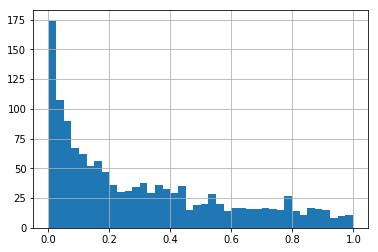

In [26]:
locate_first_occur('story')

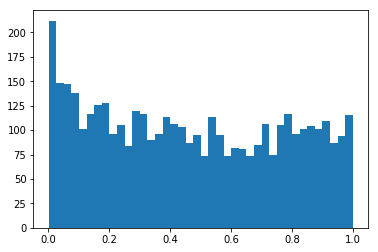

In [27]:
locate_all_occur('story')

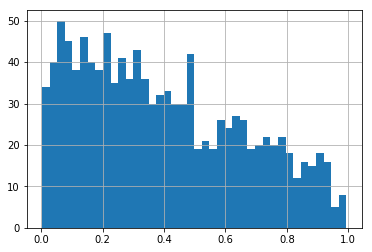

In [28]:
locate_first_occur('example')

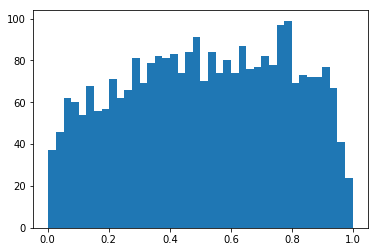

In [29]:
locate_all_occur('example')

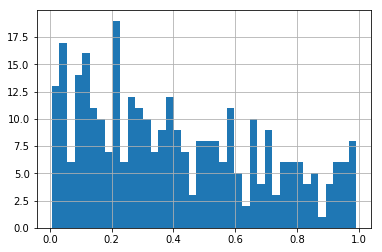

In [30]:
locate_first_occur('however')

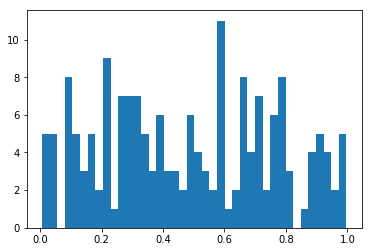

In [31]:
locate_all_occur('however')

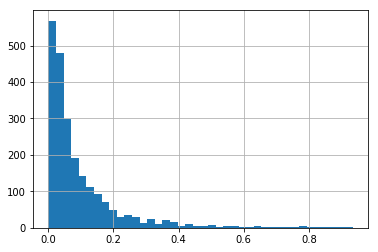

In [32]:
locate_first_occur('but')

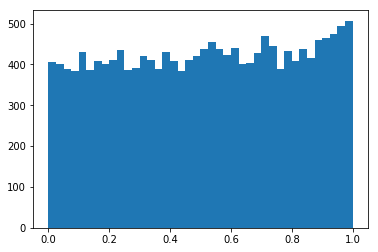

In [33]:
locate_all_occur('but')

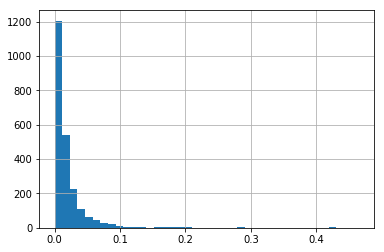

In [34]:
locate_first_occur('and')

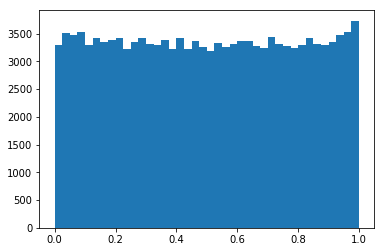

In [35]:
locate_all_occur('and')

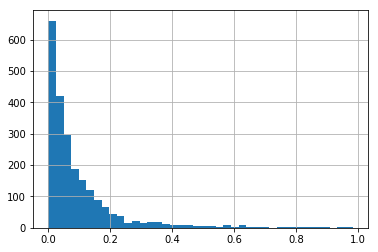

In [36]:
locate_first_occur('if')

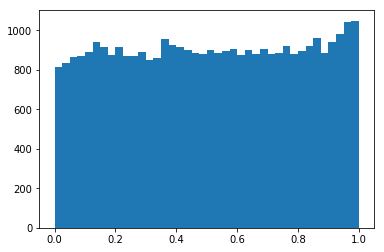

In [37]:
locate_all_occur('if')

In [38]:
def pola_subj_sequence(script, level):
    script = TextBlob(script)
    
    sd_p,sd_pola,sd_subj = [],[],[]

    if level == "words":
        ls = script.words
    elif level == "noun_phrases":
        ls = script.noun_phrases
    elif level == "sentences":
        ls = [str(s) for s in script.sentences]
        
    for p in ls:
        p_ = TextBlob(p)
        sd_p.append(p)
        sd_pola.append(p_.sentiment[0])
        sd_subj.append(p_.sentiment[1])

    return np.asarray(sd_p),np.asarray(sd_pola),np.asarray(sd_subj)

In [39]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [40]:
def three_graph(indices):
    plt.figure(figsize=(10, 6))

    # TOP 1
    plt.subplot(231)
    script = ted['transcript'][indices[0]]     # control which talk
    axes = plt.gca()
    axes.set_ylim([-1,1])
    plt.plot(pola_subj_sequence(script,'sentences')[1])

    # DOWN 1
    plt.subplot(234)
    sentences_pola = pola_subj_sequence(script,'sentences')[1]
    axes = plt.gca()
    #axes.set_xlim([xmin,xmax])
    axes.set_ylim([-0.4,0.4])
    plt.plot(running_mean(sentences_pola, 5),c = 'orange')
    plt.plot(running_mean(sentences_pola, 10),c = 'green')
    plt.plot(running_mean(sentences_pola, 20),c = 'blue')


    # TOP 2
    plt.subplot(232)
    script = ted['transcript'][indices[1]]     # control which talk
    axes = plt.gca()
    axes.set_ylim([-1,1])
    plt.plot(pola_subj_sequence(script,'sentences')[1])

    # DOWN 2
    plt.subplot(235)
    sentences_pola = pola_subj_sequence(script,'sentences')[1]
    axes = plt.gca()
    #axes.set_xlim([xmin,xmax])
    axes.set_ylim([-0.4,0.4])
    plt.plot(running_mean(sentences_pola, 5),c = 'orange')
    plt.plot(running_mean(sentences_pola, 10),c = 'green')
    plt.plot(running_mean(sentences_pola, 20),c = 'blue')

    # TOP 3
    plt.subplot(233)
    script = ted['transcript'][indices[2]]     # control which talk
    axes = plt.gca()
    axes.set_ylim([-1,1])
    plt.plot(pola_subj_sequence(script,'sentences')[1])

    # DOWN 3
    plt.subplot(236)
    sentences_pola = pola_subj_sequence(script,'sentences')[1]
    axes = plt.gca()
    #axes.set_xlim([xmin,xmax])
    axes.set_ylim([-0.4,0.4])
    plt.plot(running_mean(sentences_pola, 5),c = 'orange')
    plt.plot(running_mean(sentences_pola, 10),c = 'green')
    plt.plot(running_mean(sentences_pola, 20),c = 'blue')

## Pos/Neg Emotion Extremes

In [41]:
ted_emotion = pd.read_csv('TED_Talks_by_ID_plus-transcripts-and-LIWC-and-MFT-plus-views.csv')[['headline']+['affect', 'posemo', 'negemo', 'anx', 'anger', 'sad']]

In [42]:
ted = pd.merge(ted,ted_emotion,on='headline')

In [43]:
len(ted)

2284

In [44]:
ted['pos-neg'] = ted['posemo'] - ted['negemo']

In [45]:
#ted_copy = ted.copy()

### Most Positive
index: 853, 329, 880

In [46]:
ted.sort_values(by = 'pos-neg',ascending = False)[['headline','posemo','negemo','pos-neg','transcript']].head()

,headline,posemo,negemo,pos-neg,transcript
853,Everyday compassion at Google,8.52,0.22,8.30,So what does the happiest man in the world loo...
329,Do the green thing,9.23,1.29,7.94,"Great creativity. In times of need, we need gr..."
880,The hidden power of smiling,7.83,0.92,6.91,"When I was a child, I always wanted to be a su..."
15,An 11-year-old's magical violin,7.22,0.41,6.81,"Hi, everyone. I'm Sirena. I'm 11 years old and..."
1473,What we don't understand about trust,7.40,0.78,6.62,"So I'm going to talk about trust, and I'm goin..."


In [47]:
ted.sort_values(by = 'posemo',ascending = False)[['headline','posemo','negemo','pos-neg','transcript']].head()

,headline,posemo,negemo,pos-neg,transcript
329,Do the green thing,9.23,1.29,7.94,"Great creativity. In times of need, we need gr..."
853,Everyday compassion at Google,8.52,0.22,8.30,So what does the happiest man in the world loo...
265,"""The Dog Song""",8.42,3.41,5.01,"Id like to dedicate this next song to Carmelo,..."
880,The hidden power of smiling,7.83,0.92,6.91,"When I was a child, I always wanted to be a su..."
1675,"Please, please, people. Let's put the 'awe' ba...",7.65,1.22,6.43,"How many times have you used the word ""awesome..."


### Most Negative
index: 981, 1448, 1009

In [48]:
ted.sort_values(by = 'pos-neg',ascending = True)[['headline','posemo','negemo','pos-neg','transcript']].head()

,headline,posemo,negemo,pos-neg,transcript
981,How cyberattacks threaten real-world peace,1.75,6.53,-4.78,Good afternoon. If you have followed diplomati...
1448,For argument's sake,4.26,8.40,-4.14,"My name is Dan Cohen and I am an academic, as ..."
1009,Philosophy in prison,1.28,4.82,-3.54,"Meet Tony. He's my student. He's about my age,..."
2031,Our lonely society makes it hard to come home ...,1.71,5.03,-3.32,I worked as a war reporter for 15 years before...
1670,"Everyday objects, tragic histories",1.39,4.64,-3.25,"These are simple objects: clocks, keys, combs,..."


In [49]:
ted.sort_values(by = 'negemo',ascending = False)[['headline','posemo','negemo','pos-neg','transcript']].head()

,headline,posemo,negemo,pos-neg,transcript
1448,For argument's sake,4.26,8.40,-4.14,"My name is Dan Cohen and I am an academic, as ..."
981,How cyberattacks threaten real-world peace,1.75,6.53,-4.78,Good afternoon. If you have followed diplomati...
2256,There's no shame in taking care of your mental...,3.24,6.17,-2.93,Last year ... was hell. It was my first time ...
912,A civil response to violence,2.70,5.70,-3.00,My name is Emiliano Salinas and I'm going to t...
1037,"""Women of Hope""",4.09,5.56,-1.47,They stood together under a tree in tall grass...


### Top 3 Positive

In [50]:
indices = [853, 329, 880]
ted.iloc[indices,:]['transcript']

853    So what does the happiest man in the world loo...
329    Great creativity. In times of need, we need gr...
880    When I was a child, I always wanted to be a su...
Name: transcript, dtype: object

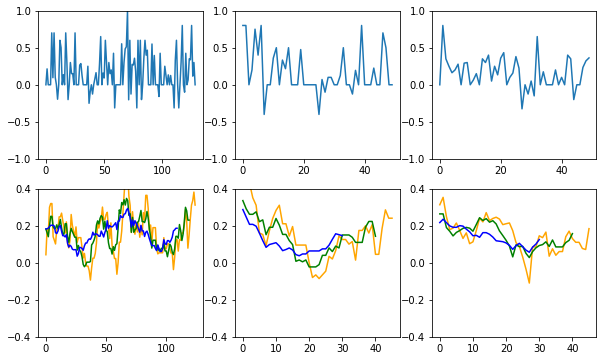

In [51]:
three_graph(indices)

### Top 3 Negative

In [52]:
indices = [981, 1448, 1009]
ted.iloc[indices,:]['transcript']

981     Good afternoon. If you have followed diplomati...
1448    My name is Dan Cohen and I am an academic, as ...
1009    Meet Tony. He's my student. He's about my age,...
Name: transcript, dtype: object

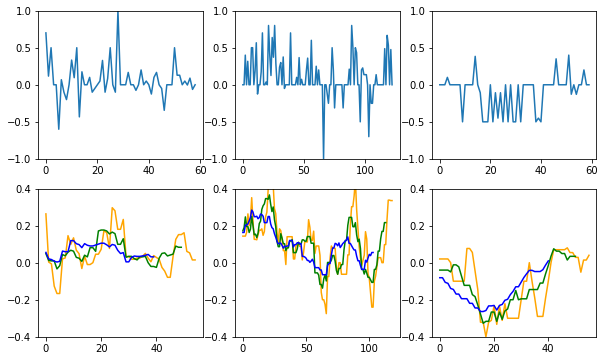

In [53]:
three_graph(indices)

## Most Viewed

In [54]:
ted.columns

Index(['comments', 'description', 'duration', 'event', 'film_date',
       'languages', 'main_speaker', 'name', 'num_speaker', 'published_date',
       'ratings', 'related_talks', 'speaker_occupation', 'tags', 'headline',
       'url', 'views', 'transcript', 'raw_transcript', 'transcript_len',
       'story_first_occur_pos', 'story_all_occur_pos',
       'example_first_occur_pos', 'example_all_occur_pos',
       'however_first_occur_pos', 'however_all_occur_pos',
       'but_first_occur_pos', 'but_all_occur_pos', 'and_first_occur_pos',
       'and_all_occur_pos', 'if_first_occur_pos', 'if_all_occur_pos', 'affect',
       'posemo', 'negemo', 'anx', 'anger', 'sad', 'pos-neg'],
      dtype='object')

In [55]:
most_viewed_data = ted.sort_values(by = 'views',ascending = False)[['headline','views','film_date','published_date','posemo','negemo','pos-neg','transcript']].head()
most_viewed_indices = most_viewed_data.index
most_viewed_data

,headline,views,film_date,published_date,posemo,negemo,pos-neg,transcript
0,Do schools kill creativity?,47227110,2006/02/25,2006/06/27,3.63,0.95,2.68,"Good morning. How are you? It's been great, h..."
637,How great leaders inspire action,34309432,2009/09/17,2010/05/04,2.68,0.61,2.07,How do you explain when things don't go as we ...
786,The power of vulnerability,31168150,2010/06/06,2010/12/23,3.71,3.05,0.66,"So, I'll start with this: a couple years ago, ..."
434,10 things you didn't know about orgasm,22270883,2009/02/06,2009/05/20,3.79,0.60,3.19,Alright. I'm going to show you a couple of ima...
1642,How to speak so that people want to listen,21594632,2013/06/10,2014/06/27,4.13,1.66,2.47,The human voice: It's the instrument we all pl...


In [56]:
least_viewed_data = ted.sort_values(by = 'views',ascending = True)[['headline','views','film_date','published_date','posemo','negemo','pos-neg','transcript']].head()
least_viewed_indices = least_viewed_data.index
least_viewed_data

,headline,views,film_date,published_date,posemo,negemo,pos-neg,transcript
1042,Plant fuels that could power a jet,155895,2011/08/17,2012/01/21,2.05,0.56,1.49,"What I'm going to do is, I'm going to explain ..."
1147,A new way to stop identity theft,174326,2012/04/27,2012/06/03,2.28,1.08,1.20,So I thought I'd talk about identity. That's s...
308,The balancing act of compassion,176245,2009/10/01,2008/10/31,4.04,1.07,2.97,One of my favorite cartoon characters is Snoop...
279,The camel's hump,185275,2002/02/02,2008/09/15,2.47,1.00,1.47,[SHIT] This is arguably the back end of the de...
301,Nature vs. humans,197139,1998/02/02,2008/10/22,2.98,0.72,2.26,You hear that this is the era of environment o...


### Does the publish time matter?

In [57]:
ted['year'] = ted['published_date'].apply(lambda string: int(string.split('/')[0]))

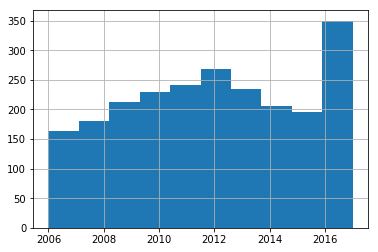

In [58]:
ted['year'].hist()

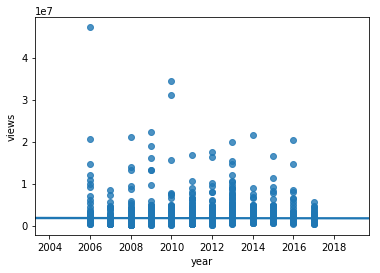

In [59]:
sns.regplot(x="year", y="views", data=ted)

In [60]:
first_published_date = datetime.strptime(ted['published_date'].sort_values()[0], '%Y/%m/%d')
first_published_date

datetime.datetime(2006, 6, 27, 0, 0)

In [61]:
last_published_date = datetime.strptime(ted['published_date'].sort_values()[len(ted['published_date'].sort_values())-1], '%Y/%m/%d')
last_count_date = datetime.strptime('2017/12/31', '%Y/%m/%d')
last_count_date

datetime.datetime(2017, 12, 31, 0, 0)

In [62]:
ted['days_since_start'] = ted['published_date'].apply(lambda x: (datetime.strptime(x, '%Y/%m/%d')-first_published_date).days)

In [63]:
ted['days_till_end'] = ted['published_date'].apply(lambda x: (last_count_date - datetime.strptime(x, '%Y/%m/%d')).days)

In [64]:
ted['views_per_day'] = ted['views']/ted['days_till_end']

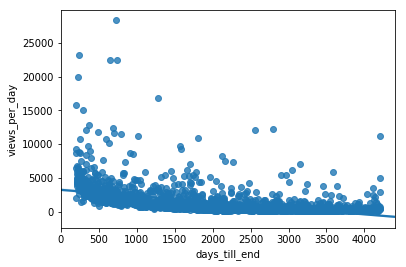

In [65]:
sns.regplot(x="days_till_end", y="views_per_day", data=ted)

Seems to suggest more recent talks get more views per day since their published, but the methods might be fundamentally flawed. See the example below: with equal views for all, the division operation implies the final shape of the product is a downward sloping curve.

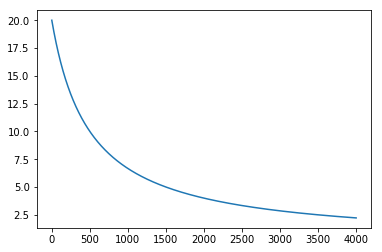

In [66]:
test_views = np.ones(4000)*10000
test_days = np.arange(500,4500)
plt.plot(np.divide(test_views,test_days))

### Resume on the pos/neg graph of the most/least viewed talks

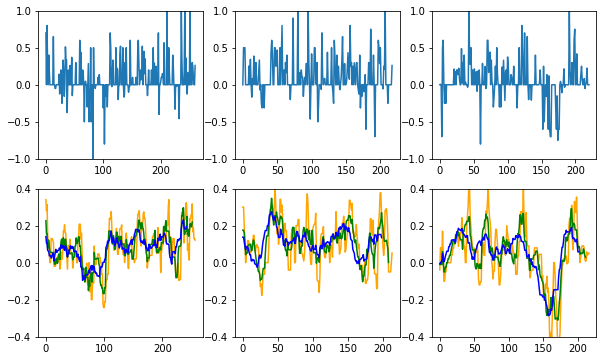

In [67]:
three_graph(most_viewed_indices)

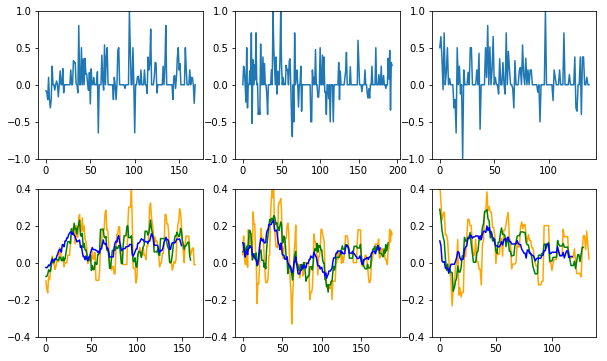

In [68]:
three_graph(least_viewed_indices)

In [69]:
views_extreme = most_viewed_data.append(least_viewed_data)
views_extreme.to_csv('views_extreme.csv')

### Tense Detector

In [70]:
import operator
def maxDict(dictionary):
    return max(dictionary.items(), key=operator.itemgetter(1))[0]

In [71]:
# https://stackoverflow.com/questions/30016904/determining-tense-of-a-sentence-python/45128430
from nltk import word_tokenize, pos_tag

def determine_tense(sentence, return_number = False):
    text = word_tokenize(sentence)
    tagged = pos_tag(text)

    tense = {}
    tense["future"] = len([word for word in tagged if word[1] in ["MD"]])
    tense["present"] = len([word for word in tagged if word[1] in ["VBP", "VBZ","VBG"]])
    tense["past"] = len([word for word in tagged if word[1] in ["VBD", "VBN"]]) 
    
    output = maxDict(tense)
    
    if return_number:
        if output == 'past':
            output = -1
        elif output == 'present':
            output = 0
        else:
            output = 1
    
    return output

In [72]:
def tenseGraph(index):
    script = TextBlob(ted.transcript[i])
    sentences = [str(s) for s in script.sentences]

    tense_seq = np.asarray([determine_tense(s,True) for s in sentences])
    #plt.plot(tense_seq)

    axes = plt.gca()
    axes.set_xlim([0,250])
    axes.set_ylim([-1.1,1.1])
    
    #axes.set_title(str(index),ted.headline[index])

    #markers_on = [int(pos) for pos in find_all_occur_position(ted.transcript[i],'if')*len(sentences)]
    plt.plot(running_mean(tense_seq, 5),c = 'orange')
    #plt.plot(running_mean(tense_seq, 10),c = 'red')
    plt.plot(running_mean(tense_seq, 20),c = 'blue')
        
    

'''
%matplotlib notebook

fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()

for i in range(0,1000):
    ax.clear()
    
    tenseGraph(i)
    fig.canvas.draw()
    time.sleep(0.3)

%matplotlib inline
'''

It seems two valleys or more are common in a medium to long ted talks, indicating that people might give examples or share past experiences in those parts. Moreover, the end is typically tipping upwards, suggesting the end has more call-to-action and thoughts on the future.

### Now let's explore the related talks network

In [74]:
txt = ted.related_talks[0]

In [75]:
import ast
ast.literal_eval(txt)

[{'id': 865,
  'hero': 'https://pe.tedcdn.com/images/ted/172559_800x600.jpg',
  'speaker': 'Ken Robinson',
  'title': 'Bring on the learning revolution!',
  'duration': 1008,
  'slug': 'sir_ken_robinson_bring_on_the_revolution',
  'viewed_count': 7266103},
 {'id': 1738,
  'hero': 'https://pe.tedcdn.com/images/ted/de98b161ad1434910ff4b56c89de71af04b8b873_1600x1200.jpg',
  'speaker': 'Ken Robinson',
  'title': "How to escape education's death valley",
  'duration': 1151,
  'slug': 'ken_robinson_how_to_escape_education_s_death_valley',
  'viewed_count': 6657572},
 {'id': 2276,
  'hero': 'https://pe.tedcdn.com/images/ted/3821f3728e0b755c7b9aea2e69cc093eca41abe1_2880x1620.jpg',
  'speaker': 'Linda Cliatt-Wayman',
  'title': 'How to fix a broken school? Lead fearlessly, love hard',
  'duration': 1027,
  'slug': 'linda_cliatt_wayman_how_to_fix_a_broken_school_lead_fearlessly_love_hard',
  'viewed_count': 1617101},
 {'id': 892,
  'hero': 'https://pe.tedcdn.com/images/ted/e79958940573cc610ccb58

In [76]:
class Talk:

    def __init__(self,index,headline):
        self.index = index
        self.headline = headline
        self.hero = ''
        self.speaker = ''
        self.duration = 0
        self.slug = ''
        self.viewed_count = 0
        self.pointed_from = []
        self.pointing_to = []
        
  
    def change_headline(self, new_headline):
        self.headline = new_headline
        
    def change_dict_parameters(self, dic):
        if dic['title'] != self.headline:
            print(f"Headline mismatch, trying to copy info of {dic['title']} into object {self.headline}")
        else:
            self.hero = dic['hero']
            self.speaker = dic['speaker']
            self.duration = dic['duration']
            self.slug = dic['slug']
            self.viewed_count = dic['viewed_count']

    def add_pointed_from(self, new_pointed_from):
        self.pointed_from.append(new_pointed_from)
        
    def add_pointing_to(self, new_pointing_to):
        self.pointing_to.append(new_pointing_to)
        

talk1 = Talk(0,'Do schools kill creativity?')
print(talk1.duration)

0


In [77]:
# pre double quote replacement
print([h for h in list(ted.headline) if '"' in h])

['How the "ghost map" helped end a killer disease', 'Singing "What I Want"', '"Kiteflyer\'s Hill"', '"What You\'ve Got"', '"Black Men Ski"', '"Thula Mama"', 'Building "self-aware" robots', 'A performance of "Mathemagic"', '"Tembererana"', 'The "bottom billion"', 'Memes and "temes"', '"Clonie"', '"Peace on Earth"', '"Mother of Pearl," "If I Had You"', '"The Dog Song"', 'The web is more than "better TV"', 'Scenes from "My Architect"', 'How bacteria "talk"', 'Playing "Pink Noise" on guitar', '"Wait It Out"', 'Claim your "manspace"', 'Robots that "show emotion"', 'How we rescued the "dancing" bears"', '"Love Is a Loaded Pistol"', 'It\'s time for "The Talk"', 'Watch me unveil "synthetic life"', 'The walk from "no" to "yes"', 'Take "the Other" to lunch', 'The future of business is the "mesh"', 'Beware online "filter bubbles"', 'We need a "moral operating system"', 'A prosthetic arm that "feels"', '"Women of Hope"', 'How to "sketch" with electronics', 'A "self-healing" asphalt', 'The emergenc

In [78]:
# double quote replacement
ted.headline = ted.headline.apply(lambda x: x.replace('"','/'))

In [79]:
# post double quote replacement
[h for h in list(ted.headline) if '"' in h]

[]

In [80]:
# create Talk object for every talk in the ted dataframe
for i in range(len(ted)):
    exec(f'talk_{i} = Talk({i},"'+ted.headline[i]+'")')

In [81]:
talks_not_found = []
for i in range(len(ted)):
    this_talk_object = eval(f'talk_{i}')
    related_talks_dicts = ast.literal_eval(ted.related_talks[i])
    for related_talk_dict in related_talks_dicts:
        try:
            headline_of_dict = related_talk_dict['title']
            object_index = ted[ted['headline'] == headline_of_dict].index[0]
            other_talk_object = eval(f'talk_{object_index}')
            other_talk_object.change_dict_parameters(related_talk_dict)
            other_talk_object.add_pointed_from(this_talk_object)
            this_talk_object.add_pointing_to(other_talk_object)
        except:
            #print(f'The talk titled {headline_of_dict} is not found in ted dataframe.')
            talks_not_found.append(headline_of_dict)
                

In [82]:
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2)) 

In [83]:
intersection(talks_not_found,list(ted.headline))

[]

In [84]:
vars(talk_0)

{'index': 0,
 'headline': 'Do schools kill creativity?',
 'hero': 'https://pe.tedcdn.com/images/ted/6b6eb940bceab359ca676a9b486aae475c1df883_2880x1620.jpg',
 'speaker': 'Ken Robinson',
 'duration': 1164,
 'slug': 'ken_robinson_says_schools_kill_creativity',
 'viewed_count': 47231612,
 'pointed_from': [<__main__.Talk at 0x1165cd198>,
 'pointing_to': [<__main__.Talk at 0x1a22db80f0>,
  <__main__.Talk at 0x1a21ae2048>]}

In [85]:
object_edge_list = []
for i in range(len(ted)):
    this_object = eval(f'talk_{i}')
    for other_object in this_object.pointing_to:
        object_edge_list.append((this_object,other_object))

print("Number of edges:", len(object_edge_list))
print(object_edge_list[:2])

Number of edges: 12473
[(<__main__.Talk object at 0x117b5a8d0>, <__main__.Talk object at 0x1a22db80f0>), (<__main__.Talk object at 0x117b5a8d0>, <__main__.Talk object at 0x1a22d99f60>)]


In [86]:
G = nx.DiGraph()

In [87]:
G.add_edges_from(object_edge_list)

In [88]:
numbers = range(len(G.nodes))

In [89]:
object_names = [f'talk_{number}' for number in numbers]

In [90]:
objects = [eval(obj_name) for obj_name in object_names]

In [91]:
# object_var to talk_i
mapping = dict(zip(objects, object_names))

In [92]:
talk_headlines = [talk.headline for talk in objects]

In [93]:
# talk_i to headline
mapping2 = dict(zip(object_names, talk_headlines))

In [94]:
heros = [talk.hero for talk in objects]

In [95]:
# talk_i to headline
mapping3 = dict(zip(talk_headlines, heros))

In [96]:
H = nx.relabel_nodes(G, mapping)

In [97]:
# pos = nx.spring_layout(H)
# nx.draw_networkx_edges(H, pos, node_size = 10)

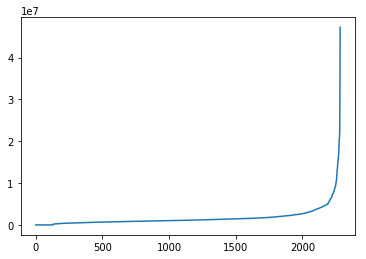

In [98]:
viewed_counts_list = [talk.viewed_count for talk in objects]
plt.plot(np.asarray(sorted(viewed_counts_list)))

In [99]:
thres_for_top= np.percentile(sorted(viewed_counts_list),80)
print(thres_for_top)

1991586.4000000013


In [100]:
bottom_talks = [talk for talk in objects if talk.viewed_count < thres_for_top]

In [101]:
H = nx.relabel_nodes(G, mapping)
for talk in bottom_talks:
    H.remove_node(mapping[talk])

In [103]:
# pos = nx.spring_layout(H)
# nx.draw_networkx_edges(H, pos, node_size = 500)

In [104]:
P = nx.relabel_nodes(H, mapping2)

In [105]:
days_list = list(ted['days_till_end'])
OldMax = days_list[0]
OldMin = days_list[-1]
NewMax = 255 # max blue, red will be (255-blue)
NewMin = 0

hex_code_list = []

for OldValue in days_list:
    NewValue = int((((OldValue - OldMin) * (NewMax - NewMin)) / (OldMax - OldMin)) + NewMin)
    rgb_tuple = (255-NewValue,0,NewValue)
    hex_code = '#%02x%02x%02x' % rgb_tuple
    hex_code_list.append(hex_code)
    
ted['hex_code_r_new_b_old'] = hex_code_list

In [ ]:
#from pyvis.network import Network
from pyvis import network as net

ted_net = net.Network(height="750px", width="100%", bgcolor="#ffffff", font_color="black",notebook = True)
ted_net.from_nx(P)

# set the physics layout of the network
ted_net.barnes_hut()

neighbor_map = ted_net.get_adj_list()

# add neighbor data to node hover data
for node in ted_net.nodes:
    hero = mapping3[node["id"]]
    node["title"] = node["id"]+"<br>Related talks:<br>" + "<br>".join(neighbor_map[node["id"]]) #f'<img src="{hero}" height="40" width="40">'
    node["value"] = int(ted[ted['headline'] == node["id"]]['views'])
    node["color"] = str(ted[ted['headline'] == node["id"]][['hex_code_r_new_b_old']]).split()[-1]
    node['labelHighlightBold'] = True
    # node["mass"] = node["value"]



ted_net.show("ted.html")

In [93]:
import statsmodels.api as sm
def linreg_summary(y,x,df,log = False,intercept = True):

    x_list = x if isinstance(x, list) else [x]
    print('linreg', y, "~", x_list)    

    df['intercept'] = 1
    intercept_list = ['intercept'] if intercept else []
    
    if type(log) != list:   # True / False
        if log:
            lm=sm.OLS(np.log(df[y]+1),np.log(df[intercept_list + x_list]+1))
        else:
            lm=sm.OLS(df[y],df[intercept_list + x_list])
    else:   # log = [True, False]    log(y) ~ x
        if len(log) != 2:
            print("Error, not defined.")
        else:
            if log[0]:
                y = np.log(df[y]+1)
            if log[1]:
                x = np.log(df[intercept_list + x_list]+1)
            lm=sm.OLS(y,x)
    
    slr_results = lm.fit()
    
    df.drop('intercept',axis = 1,inplace = True)
    
    return slr_results.summary()

